In [9]:
from tensorflow.keras.models import load_model

model=load_model(r'ecg_client\final_model_1d_multihead_attention_gru_adamw_SMOTE.keras')
print(model.summary())

OSError: SavedModel file does not exist at: ecg_client\final_model_1d_multihead_attention_gru_adamw_SMOTE.keras/{saved_model.pbtxt|saved_model.pb}

In [11]:
from tensorflow.keras.models import load_model
model=load_model(r'..\final_model_1d_multihead_attention_gru_adamw_SMOTETEST\saved_model.pb')
print(model.summary())

OSError: SavedModel file does not exist at: ..\final_model_1d_multihead_attention_gru_adamw_SMOTETEST\saved_model.pb/{saved_model.pbtxt|saved_model.pb}

Epoch 1/40
508/508 [==============================] - 20s 39ms/step - loss: 1.0025 - accuracy: 0.5655 - val_loss: 0.8089 - val_accuracy: 0.6550
Epoch 2/40
508/508 [==============================] - 19s 37ms/step - loss: 0.7883 - accuracy: 0.6774 - val_loss: 0.7483 - val_accuracy: 0.6892
Epoch 3/40
508/508 [==============================] - 21s 41ms/step - loss: 0.7058 - accuracy: 0.7220 - val_loss: 0.6590 - val_accuracy: 0.7267
Epoch 4/40
508/508 [==============================] - 19s 37ms/step - loss: 0.6515 - accuracy: 0.7497 - val_loss: 0.6421 - val_accuracy: 0.7454
Epoch 5/40
508/508 [==============================] - 19s 37ms/step - loss: 0.6089 - accuracy: 0.7658 - val_loss: 0.6374 - val_accuracy: 0.7481
Epoch 6/40
508/508 [==============================] - 19s 37ms/step - loss: 0.5567 - accuracy: 0.7872 - val_loss: 0.5752 - val_accuracy: 0.7747
Epoch 7/40
508/508 [==============================] - 20s 39ms/step - loss: 0.5316 - accuracy: 0.7967 - val_loss: 0.5337 - val_accuracy:

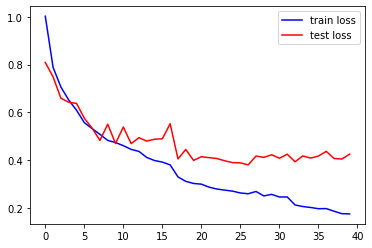

127/127 [==============================] - 1s 7ms/step - loss: 0.4245 - accuracy: 0.8577
Test Accuracy: 0.8577


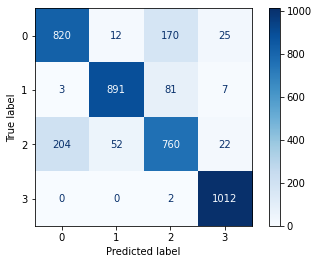

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = r'..\ecg_client\physionet2017_balanced_SMOTE.csv'
data = pd.read_csv(file_path)

# 提取ECG信号和标签
X = data.iloc[:, :-2].values  # 最后两列是name和label
y = data['label'].values

# 标签编码
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据形状调整为 (样本数, 时间步长, 特征数)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 将标签转换为one-hot编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# 多头自注意力层定义
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, units):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.units = units
        self.Wq = [tf.keras.layers.Dense(units) for _ in range(num_heads)]
        self.Wk = [tf.keras.layers.Dense(units) for _ in range(num_heads)]
        self.Wv = [tf.keras.layers.Dense(units) for _ in range(num_heads)]
        self.dense = tf.keras.layers.Dense(units)

    def call(self, inputs):
        attention_outputs = []
        for i in range(self.num_heads):
            Q = self.Wq[i](inputs)
            K = self.Wk[i](inputs)
            V = self.Wv[i](inputs)

            attention_scores = tf.matmul(Q, K, transpose_b=True)
            attention_scores = attention_scores / tf.sqrt(tf.cast(self.units, tf.float32))
            attention_weights = tf.nn.softmax(attention_scores, axis=-1)
            attention_output = tf.matmul(attention_weights, V)
            attention_outputs.append(attention_output)

        concat_attention = tf.concat(attention_outputs, axis=-1)
        output = self.dense(concat_attention)
        return output

# SENet_GRU模型定义，使用1D卷积和多头自注意力
def SENet_GRU(ecg_input):
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=20, strides=3, padding='same', activation=tf.nn.relu)(ecg_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=3)(x)

    x = tf.keras.layers.Conv1D(filters=32, kernel_size=15, strides=1, padding='same', activation=tf.nn.relu)(x)
    x = SEBlock(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv1D(filters=16, kernel_size=10, strides=1, padding='same', activation=tf.nn.relu)(x)
    x = SEBlock(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)

    # 增加一层卷积
    x = tf.keras.layers.Conv1D(filters=8, kernel_size=5, strides=1, padding='same', activation=tf.nn.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)

    x = MultiHeadSelfAttention(num_heads=4, units=32)(x)  # 多头自注意力层

    # 增加一层GRU和Dropout
    x = tf.keras.layers.GRU(32, return_sequences=True)(x)
    x = tf.keras.layers.GRU(32)(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # 增加全连接层和神经元数量
    x = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(x)
    output = tf.keras.layers.Dense(units=4, activation=tf.nn.softmax)(x)
    return output

def SEBlock(inputs, reduction=16, if_train=True):
    x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    x = tf.keras.layers.Dense(int(x.shape[-1]) // reduction, use_bias=False, activation=tf.keras.activations.relu,
                              trainable=if_train)(x)
    x = tf.keras.layers.Dense(int(inputs.shape[-1]), use_bias=False, activation=tf.keras.activations.hard_sigmoid,
                              trainable=if_train)(x)
    return tf.keras.layers.Multiply()([inputs, x])

# 输入层
ecg_input = tf.keras.Input(shape=(X_train.shape[1], 1))

# 构建模型
output = SENet_GRU(ecg_input)
model = tf.keras.Model(inputs=ecg_input, outputs=output)

# 编译模型，使用AdamW优化器和学习率调度器
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 学习率调度器
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler]
)
plt.plot(history.epoch,history.history['loss'],color='blue',label='train loss')
plt.plot(history.epoch,history.history['val_loss'],color="red",label='test loss')
plt.legend()
plt.show()
# 评估模型在测试集上的表现
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 预测测试集
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 生成混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [37]:
# 保存最终模型为SavedModel格式

model.save(r'..\ecg_model')
# model.export('final_model_1d_multihead_attention_gru_adamw_SMOTETEST.pb')

INFO:tensorflow:Assets written to: ..\ecg_model\assets


In [38]:
from tensorflow.keras.models import load_model
model=load_model(r'..\ecg_model')
print(model.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 667, 64)      1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 667, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 222, 64)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [39]:
import tensorflow as tf
converter=tf.lite.TFLiteConverter.from_saved_model(r'..\ecg_model')
tflite_model=converter.convert()

with open('ecg_model.lite','wb') as f:
    f.write(tflite_model)